In [1]:
!pip install tensorflow==2.9.1

  Obtaining dependency information for tensorflow==2.9.1 from https://files.pythonhosted.org/packages/0b/3f/57bb9bbd2dfecba3659aedffb54bb837e83ccba81f217cb744f26d453048/tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for flatbuffers<2,>=1.12 from https://files.pythonhosted.org/packages/eb/26/712e578c5f14e26ae3314c39a1bdc4eb2ec2f4ddc89b708cf8e0a0d20423/flatbuffers-1.12-py2.py3-none-any.whl.metadata
  Obtaining dependency information for keras<2.10.0,>=2.9.0rc0 from https://files.pythonhosted.org/packages/ff/ff/f25909606aed26981a8bd6d263f89d64a20ca5e5316e6aafb4c75d9ec8ae/keras-2.9.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for keras-preprocessing>=1.1.1 from https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for protobuf<3.20,>=3.9.2 from https://fi

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [3]:
train_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
...,...,...
5116,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
5117,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
5118,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
5119,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented


In [5]:
# Generate  test data paths with labels
test_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
test_df

,filepaths,labels
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
...,...,...
1274,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1275,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1276,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1277,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented


In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5121 validated image filenames belonging to 4 classes.
Found 767 validated image filenames belonging to 4 classes.
Found 512 validated image filenames belonging to 4 classes.


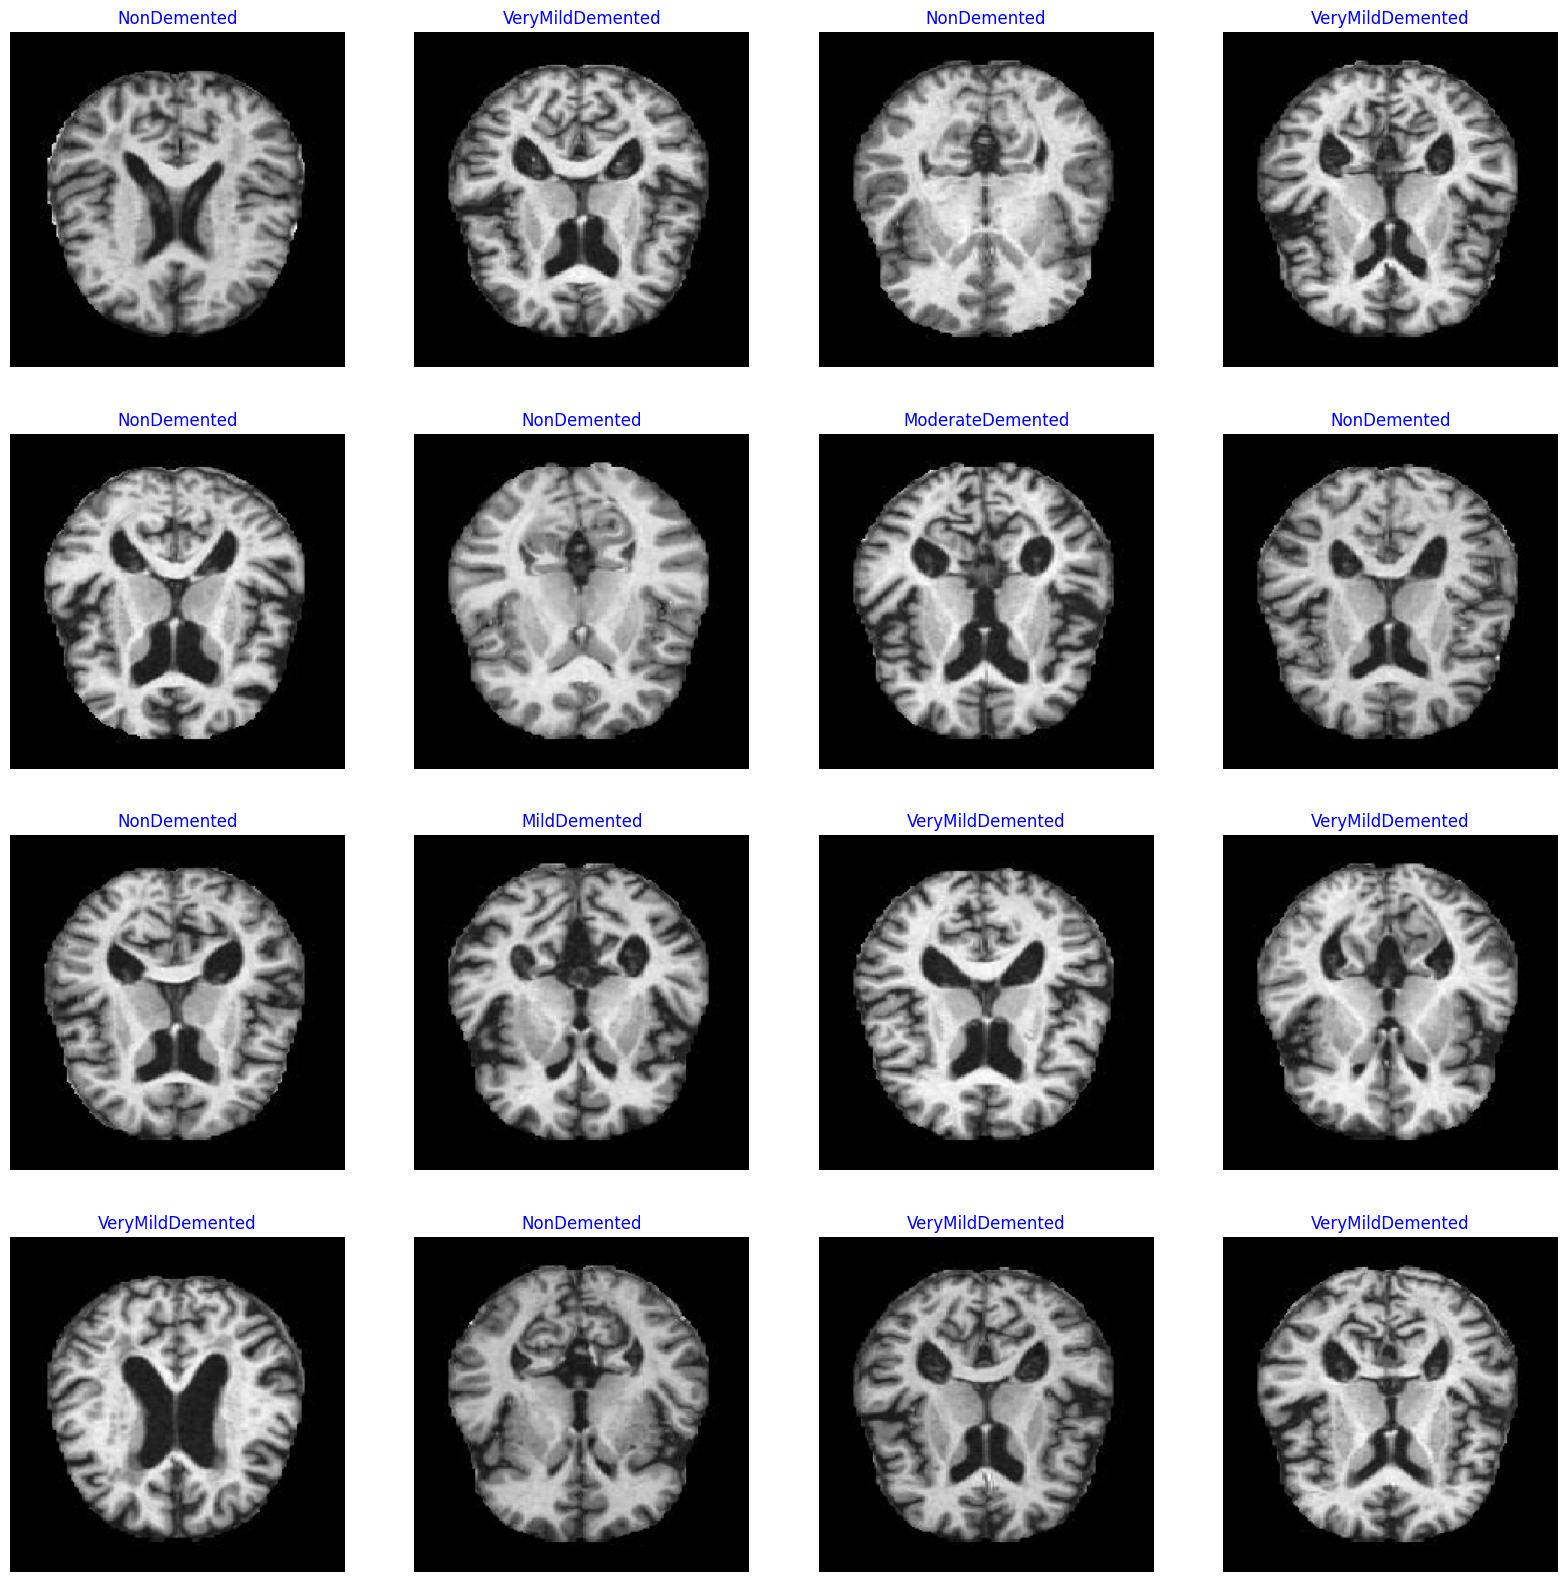

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4,383,655
Trainable params: 4,339,072
Non-t

In [11]:
batch_size = 20   # set batch size for training
epochs =  50  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)


Epoch 1/50
321/321 [==============================] - 56s 141ms/step - loss: 6.7986 - accuracy: 0.5419 - val_loss: 5.5256 - val_accuracy: 0.3533
Epoch 2/50
321/321 [==============================] - 40s 125ms/step - loss: 4.1742 - accuracy: 0.6919 - val_loss: 3.5147 - val_accuracy: 0.6206
Epoch 3/50
321/321 [==============================] - 40s 124ms/step - loss: 2.5934 - accuracy: 0.8350 - val_loss: 2.4967 - val_accuracy: 0.6506
Epoch 4/50
321/321 [==============================] - 40s 125ms/step - loss: 1.5684 - accuracy: 0.9166 - val_loss: 1.8653 - val_accuracy: 0.6623
Epoch 5/50
321/321 [==============================] - 40s 125ms/step - loss: 0.9645 - accuracy: 0.9443 - val_loss: 1.6672 - val_accuracy: 0.6454
Epoch 6/50
321/321 [==============================] - 40s 125ms/step - loss: 0.6344 - accuracy: 0.9617 - val_loss: 1.2727 - val_accuracy: 0.7027
Epoch 7/50
321/321 [==============================] - 40s 125ms/step - loss: 0.4448 - accuracy: 0.9717 - val_loss: 1.2796 - val_ac

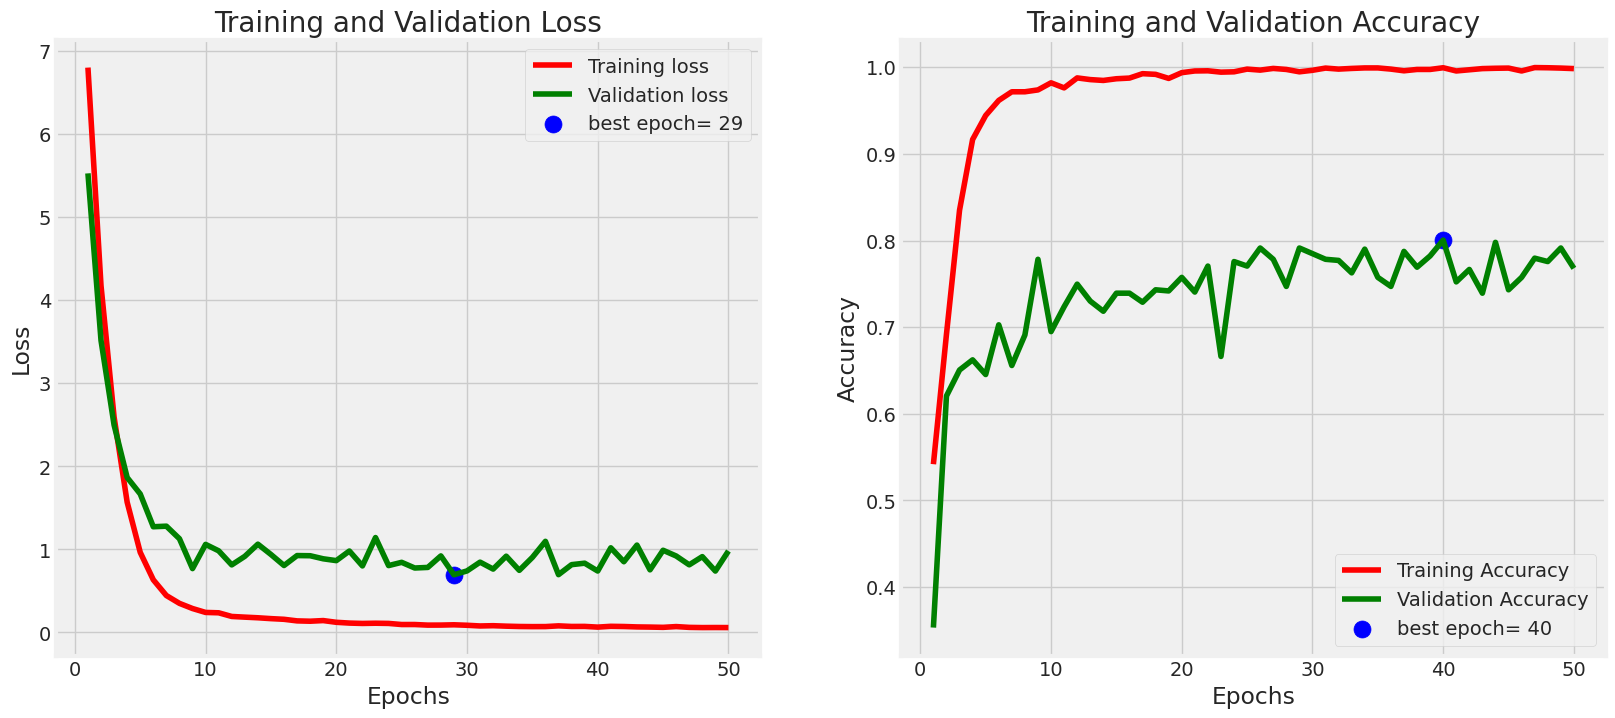

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 [==============================] - 1s 102ms/step - loss: 0.8280 - accuracy: 0.7734
Train Loss:  0.07983075082302094
Train Accuracy:  0.984375
--------------------
Validation Loss:  1.0943078994750977
Validation Accuracy:  0.7265625
--------------------
Test Loss:  0.8280189633369446
Test Accuracy:  0.7734375


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

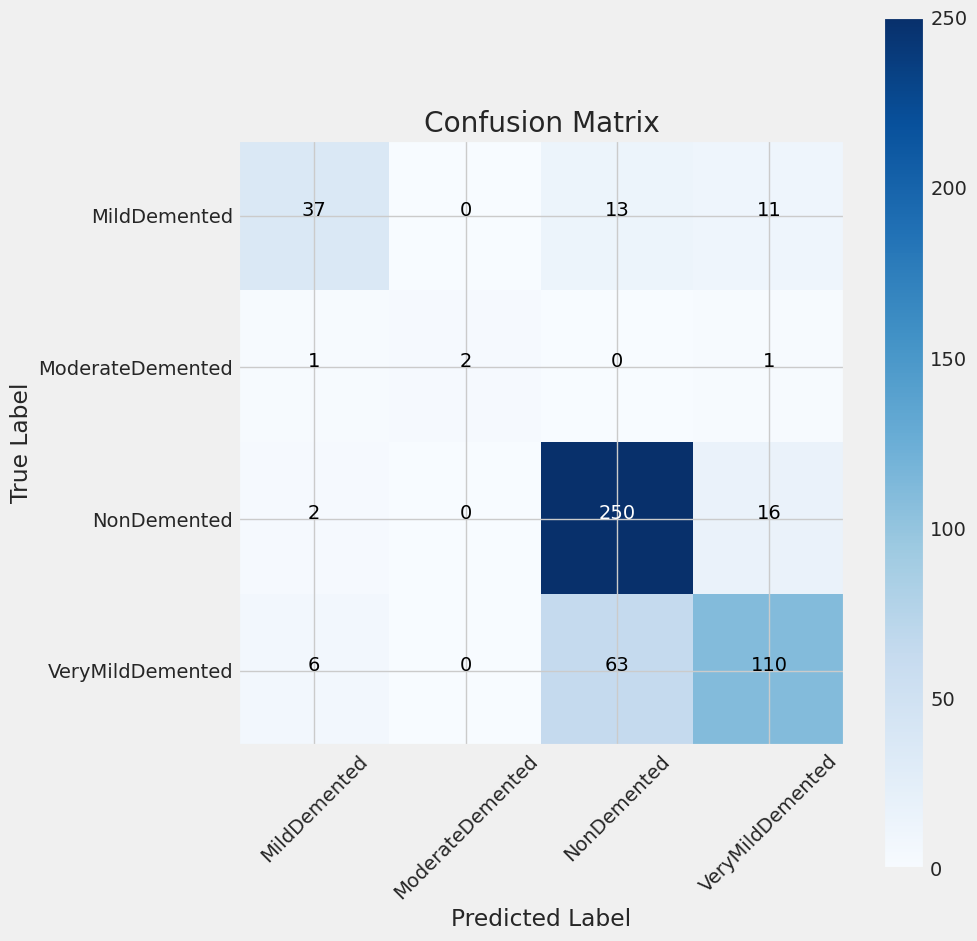

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

    MildDemented       0.80      0.61      0.69        61
ModerateDemented       1.00      0.50      0.67         4
     NonDemented       0.77      0.93      0.84       268
VeryMildDemented       0.80      0.61      0.69       179

        accuracy                           0.78       512
       macro avg       0.84      0.66      0.72       512
    weighted avg       0.78      0.78      0.77       512



In [17]:
#Save the model
model.save('model.h5')

In [18]:
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [19]:
image_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (46).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 1s/step
VeryMildDemented
